### LightGBM + ADSTuner: predicting causl
* two models, one for causal and the other one for registerd
* added feature engineering
* added year, removed temp
* removing day I got the best results. (The range of days in the train set don't match with test set)

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

import seaborn as sns

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

from sklearn.metrics import make_scorer

# see utils.py
from utils import add_features, rmsle, train_encoders, apply_encoders
from utils import show_tuner_results, show_categoricals

# set seaborn look&feel
sns.set()

import logging

In [2]:
# globals and load train dataset

# number of folds for K-fold cv in ADSTuner
FOLDS = 5

# in secs
TIME_BUDGET = 7200

FILE_TRAIN = "train.csv"
FILE_TEST = "test.csv"

# train dataset
data_orig = pd.read_csv(FILE_TRAIN)

In [3]:
#
# add features
#
data_extended = add_features(data_orig)

# have a look
data_extended.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,2012
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,2012
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,2012
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,2012
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23,2012


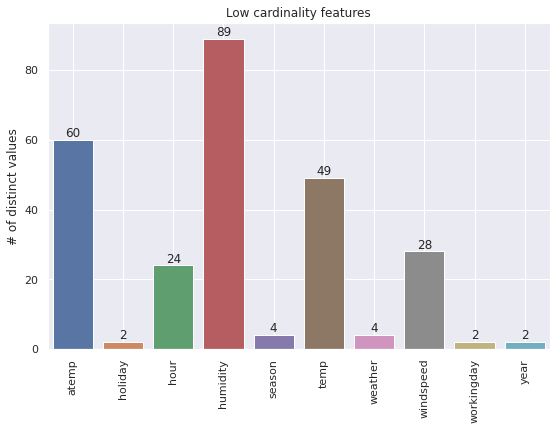

In [4]:
# give a better look at cols with low cardinality
# to decide which one we want to treat as categoricals

# in utils.py
# THR = 100
show_categoricals(data_extended, 100)

In [5]:
# ok, we will treat as categorical: holiday, hour, season, weather, windspeed (?), workingday, year

In [6]:
all_columns = data_extended.columns

# cols to be ignored
# atemp and temp are strongly correlated (0.98) we're taking only one
del_columns = ["datetime", "temp"]

# drop ignored columns
data_used = data_extended.drop(del_columns, axis=1)

# let's code categorical
# windspeed need a special treatment
le_list = train_encoders(data_used)

# coding
data_used = apply_encoders(data_used, le_list)

train for coding: season 
train for coding: weather 
train for coding: year 

Coding: season 
Coding: weather 
Coding: year 


In [7]:
cat_cols = ["season", "holiday", "workingday", "weather", "hour", "year"]
num_cols = ["atemp", "humidity", "windspeed"]
target_columns = ["casual", "registered", "count"]
features = sorted(cat_cols + num_cols)

# define indexes for cat_cols
# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(features) if col in cat_cols]

print("All columns:", len(all_columns))
print("Ignored columns:", len(del_columns))
print("Categorical columns:", len(cat_cols))
print("Numerical columns:", len(num_cols))
print(f"All targets: {len(target_columns)}")
print("All the features", len(features))

All columns: 14
Ignored columns: 2
Categorical columns: 6
Numerical columns: 3
All targets: 3
All the features 9


### ADSTuner session: first model, target = casual

In [8]:
TARGET = "casual"

#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {
    "n_estimators": CategoricalDistribution([1000, 2000, 3000, 4000, 5000, 6000]),
    "learning_rate": LogUniformDistribution(low=1e-5, high=1e-2),
    "max_depth": IntUniformDistribution(5, 10),
    "use_best_model": True,
    "categorical_feature": cat_columns_idxs,
}

alg_reg = lgb.LGBMRegressor()

# define the scorer function for ADSTuner, see def for rmsle before
scorer = make_scorer(rmsle, greater_is_better=False)

# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(
    alg_reg, cv=FOLDS, strategy=params, scoring=scorer, study_name="study2"
)

x_train = data_used[features]
y_train = data_used[TARGET]

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

[I 2022-03-01 23:32:58,224] A new study created in RDB with name: study2


In [19]:
# get the status to see if completed
tuner.get_status()

<State.COMPLETED: 5>

In [22]:
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has completed 453 trials

The best trial is the #: 88
Parameters for the best trial are: {'learning_rate': 0.0052202070749113195, 'max_depth': 10, 'n_estimators': 3000}
The metric used to optimize is: rmsle, greater_is_better=False
The best score is: -0.7251


In [24]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
    by=["value"], ascending=False
)

result_df.head(5)

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,user_attrs_mean_fit_time,user_attrs_mean_score_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
88,88,-0.725081,2022-03-01 23:50:20.666479,2022-03-01 23:50:33.627974,0 days 00:00:12.961495,0.005220,10,3000,2.253394,0.301892,...,"rmsle, greater_is_better=False",-0.881774,-0.563149,-0.986961,-0.616002,-0.577516,0.059220,0.008069,0.174945,COMPLETE
118,118,-0.725955,2022-03-01 23:58:26.390834,2022-03-01 23:58:48.155772,0 days 00:00:21.764938,0.002404,9,5000,3.820056,0.492591,...,"rmsle, greater_is_better=False",-0.893850,-0.584325,-0.961221,-0.605877,-0.584501,0.079683,0.013045,0.166148,COMPLETE
448,448,-0.726633,2022-03-02 01:31:30.524482,2022-03-02 01:31:51.572315,0 days 00:00:21.047833,0.003718,9,5000,3.650665,0.514680,...,"rmsle, greater_is_better=False",-0.868911,-0.586095,-0.973126,-0.617903,-0.587128,0.083664,0.012777,0.162503,COMPLETE
146,146,-0.727563,2022-03-02 00:07:27.525142,2022-03-02 00:07:52.738533,0 days 00:00:25.213391,0.003451,9,6000,4.402906,0.598864,...,"rmsle, greater_is_better=False",-0.882102,-0.577467,-0.983204,-0.611054,-0.583986,0.090874,0.013883,0.170852,COMPLETE
70,70,-0.728506,2022-03-01 23:46:21.259704,2022-03-01 23:46:34.258165,0 days 00:00:12.998461,0.004517,9,3000,2.260702,0.302026,...,"rmsle, greater_is_better=False",-0.882562,-0.583363,-0.984344,-0.617343,-0.574917,0.048286,0.007628,0.170997,COMPLETE


In [25]:
%%time

model2 = lgb.LGBMRegressor(**tuner.best_params)

model2.fit(x_train, y_train, categorical_feature=cat_columns_idxs)

CPU times: user 11.1 s, sys: 23.2 ms, total: 11.1 s
Wall time: 2.79 s


LGBMRegressor(learning_rate=0.0052202070749113195, max_depth=10,
              n_estimators=3000)

In [26]:
import pickle

# saving the model best params
tuner.best_params

with open("model2.pkl", "wb") as mode1_file:
    pickle.dump(tuner.best_params, mode1_file)